In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from app import db, WalliStat
import plotly.graph_objs as go       
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_dark"  #"plotly_white" 

## Read back `hourly` data from database

In [2]:
year = dt.date.today().year

In [3]:
wss = db.session.query(WalliStat).filter(WalliStat.campaign_id==0,
                                         WalliStat.datetime>=dt.date(year,1,1),
                                         WalliStat.datetime< dt.date(year,12,31)).all()
df = WalliStat.to_dataframe(wss)
df.tail(2)

,datetime,charging_state,I_L1,I_L2,I_L3,temperature,V_L1,V_L2,V_L3,extern_lock_state,power_kW,energy_pwr_on,energy_kWh,I_max_cfg,I_min_cfg,modbus_watchdog_timeout,remote_lock,I_max_cmd,I_fail_safe,campaign_id
id,,,,,,,,,,,,,,,,,,,,
2801,2022-01-07 16:00:00,5,0.0,0.0,0.0,11.9,234,234,235,1,0.0,685.912,866.591,10,10,15000,1,10.0,10.0,0
2802,2022-01-07 17:00:00,5,0.0,0.0,0.0,11.6,229,230,234,1,0.0,685.912,866.591,10,10,15000,1,10.0,10.0,0


## Remove non-useful columns

In [4]:
df.columns

Index(['datetime', 'charging_state', 'I_L1', 'I_L2', 'I_L3', 'temperature',
       'V_L1', 'V_L2', 'V_L3', 'extern_lock_state', 'power_kW',
       'energy_pwr_on', 'energy_kWh', 'I_max_cfg', 'I_min_cfg',
       'modbus_watchdog_timeout', 'remote_lock', 'I_max_cmd', 'I_fail_safe',
       'campaign_id'],
      dtype='object')

In [5]:
df = df.drop(['I_L1', 'I_L2', 'I_L3', 'V_L1', 'V_L2', 'V_L3', 'extern_lock_state', 'charging_state', 
              'energy_pwr_on', 'I_max_cfg', 'I_min_cfg', 'modbus_watchdog_timeout', 'power_kW', 
              'remote_lock', 'I_max_cmd', 'I_fail_safe', 'campaign_id'], axis=1).set_index("datetime")
df.tail()

,temperature,energy_kWh
datetime,,
2022-01-07 13:00:00,11.3,866.591
2022-01-07 14:00:00,11.6,866.591
2022-01-07 15:00:00,11.9,866.591
2022-01-07 16:00:00,11.9,866.591
2022-01-07 17:00:00,11.6,866.591


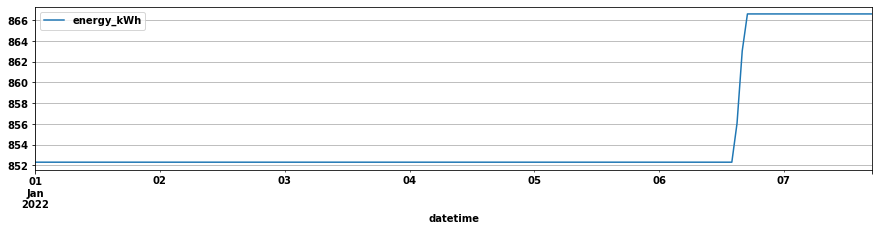

In [7]:
import matplotlib.pyplot as plt
df[["energy_kWh"]].plot(figsize=(15,3), grid="both");

In [10]:
df.shape

(162, 3)

## Calculated delta Energy

In [9]:
df["charged_kWh"] = df["energy_kWh"].diff()
df.head()

,temperature,energy_kWh,charged_kWh
datetime,,,
2022-01-01 00:00:00,19.1,852.318,NaN
2022-01-01 01:00:00,18.7,852.318,0.0
2022-01-01 02:00:00,18.5,852.318,0.0
2022-01-01 03:00:00,17.9,852.318,0.0
2022-01-01 04:00:00,17.5,852.318,0.0


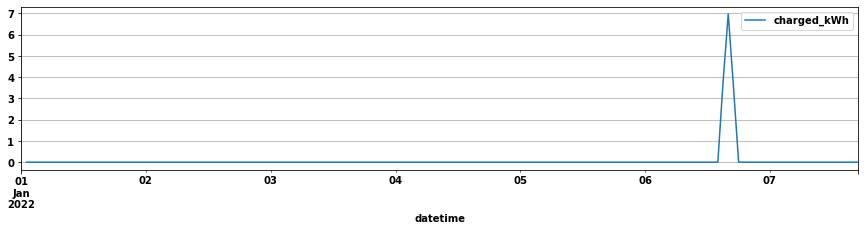

In [11]:
df[['charged_kWh']].plot(figsize=(15,3), grid="both");

## Analyze `charged_kWh` spikes

In [10]:
pd.options.display.min_rows = 100


In [11]:
df[df.index.date == dt.date(2021, 10, 29)]

,temperature,energy_kWh,charged_kWh
datetime,,,
2021-10-29 00:00:00,17.5,528.674,0.0
2021-10-29 01:00:00,17.3,528.674,0.0
2021-10-29 02:00:00,16.7,528.674,0.0
2021-10-29 03:00:00,16.4,528.674,0.0
2021-10-29 04:00:00,16.1,528.674,0.0
2021-10-29 05:00:00,16.1,528.674,0.0
2021-10-29 06:00:00,15.5,528.674,0.0
2021-10-29 07:00:00,15.2,528.676,0.002
2021-10-29 08:00:00,15.2,529.933,1.257


--> `charged_kWh` spikes are explainable. The **parking heater** is used on regular workdays (non home office) in the morning between 7:00 and 8:00. Also those heating periods are shorter than one hour, so they don't necessarily show up in the `power_kW` signal. 

## Create a Github-like maps

In [12]:
df["date"] = [idx.date() for idx in df.index]
df["weekday"] = [idx.day_of_week for idx in df.index]
df["week"] = [idx.weekofyear for idx in df.index]
df["month"] = [idx.month for idx in df.index]
df.sample(6)

,temperature,energy_kWh,charged_kWh,date,weekday,week,month
datetime,,,,,,,
2021-11-17 17:00:00,16.7,629.89,0.718,2021-11-17,2,46,11
2021-12-14 11:00:00,13.4,784.139,0.0,2021-12-14,1,50,12
2021-09-30 20:00:00,28.0,297.189,5.072,2021-09-30,3,39,9
2021-09-27 19:00:00,30.4,273.7,0.0,2021-09-27,0,39,9
2021-10-15 09:00:00,15.2,404.631,0.0,2021-10-15,4,41,10
2021-10-30 07:00:00,15.2,544.909,0.0,2021-10-30,5,43,10


In [13]:
zeros = pd.DataFrame(columns=np.arange(1, 53, dtype=int), data=np.zeros(shape=(7, 52)))
wks = df.pivot_table(index="weekday", columns="week", values="charged_kWh", aggfunc="sum") + zeros
wks.iloc[:,35:45]

,36,37,38,39,40,41,42,43,44,45
weekday,,,,,,,,,,
0,NaN,0.000,0.000,0.000,18.800,24.526,0.000,0.000,0.0,0.000
1,NaN,0.000,0.000,18.417,1.026,0.947,0.000,26.840,0.0,27.127
2,NaN,26.832,24.693,0.000,0.000,18.283,23.187,1.735,0.0,1.650
3,NaN,0.000,0.000,18.232,30.700,0.000,0.499,22.948,0.0,23.915
4,NaN,15.657,25.839,0.000,0.000,1.249,22.473,16.235,0.0,0.000
5,NaN,0.000,0.000,0.000,0.000,25.112,0.000,0.000,0.0,0.000
6,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000


In [14]:
fig = px.imshow(wks, labels={"x": "calender week", "y": "", "color": "charged_kWh"},
                color_continuous_scale='Greens', width=1000, height=300)
fig.update_layout(yaxis = {"tickmode": 'array',
                           "tickvals": [ 0,    1,    2,    3,    4,    5,    6  ],
                           "ticktext": ['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su']})
fig.show()

## Create temperature chart

,temperature max,temperature mean,temperature min
date,,,
2021-12-17,19.4,14.6875,12.8
2021-12-18,14.6,12.1625,11.6
2021-12-19,11.3,10.8000,10.4


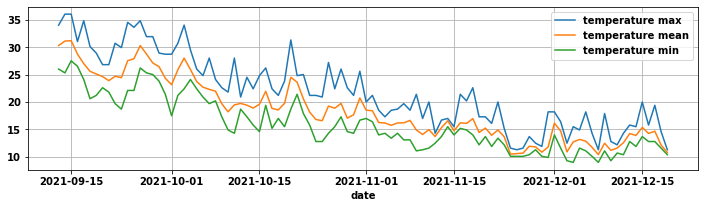

In [15]:
temps = df[["temperature", "date"]].groupby(by="date").agg(["max", "mean", "min"])
temps.columns = [f"temperature {c}" for c in temps.columns.droplevel()]
temps.plot(figsize=(12,3), grid="both");
temps.tail(3)

In [16]:
fig = go.Figure()
for col in temps.columns:
    fig.add_trace(go.Scatter(x=temps.index, y=temps[col], name=col))
fig.update_layout(width=1000, height=300, margin=dict(l=10, r=10, b=10, t=10))
fig.show()

## charging trend

In [17]:
kwh = df[["date", "charged_kWh"]].groupby("date").agg("sum")
kwh["rolling_mean"] = kwh["charged_kWh"].rolling(10, win_type="triang", center=True).mean()
kwh["mean"] = [kwh.charged_kWh.mean()] * kwh.shape[0]
kwh.tail()

,charged_kWh,rolling_mean,mean
date,,,
2021-12-15,31.068,7.53486,6.671337
2021-12-16,0.000,NaN,6.671337
2021-12-17,19.263,NaN,6.671337
2021-12-18,0.000,NaN,6.671337
2021-12-19,0.000,NaN,6.671337


In [18]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=kwh.index, y=kwh.charged_kWh, mode="markers", name="charged_kWh"))
fig.add_trace(go.Scatter(x=kwh.index, y=kwh.rolling_mean, name="rolling_mean"))
fig.add_trace(go.Scatter(x=kwh.index, y=kwh["mean"], name="mean"))
fig.update_layout(width=1000, height=300, margin=dict(l=10, r=10, b=10, t=10))
fig.show();